In [5]:
import torch
import json

from gcd_data_manipulation import ClusterDataset
from gcd_data_manipulation import prepare_data

# Load data

In [18]:
job_id = 6318371744 # test dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open('columns_selection.json') as f:
    columns_selection = json.load(f)

columns_to_consider = columns_selection['GWT_efficiency_1']

preprocessed_data = prepare_data(f'../data/task-usage_job-ID-{job_id}_total.csv', columns_to_consider, aggr_type='mean')

# TODO change parameters to include testset
test_data = ClusterDataset(preprocessed_data, training=True, split_percentage=1)
test_data.values.to(device)

print(len(test_data))

<class 'numpy.ndarray'>
57


# Test Model

## Load Model

In [19]:
from shared_workspace_module import SharedWorkspaceModule
import torch.nn as nn

checkpoint = torch.load('../models/gwt_models/gwt_model_exp_01.pth')

args = checkpoint['model_args']
print(f'last epoch: {checkpoint["epoch"]}')
print(f'last loss: {checkpoint["loss"]}')

model = SharedWorkspaceModule(
    h_dim=args.h_dim,
    ffn_dim=args.ffn_dim,
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    dropout=args.dropout,
    shared_memory_attention=args.shared_memory_attention,
    share_vanilla_parameters=args.share_vanilla_parameters,
    use_topk=args.use_topk,
    topk=args.topk,
    mem_slots=args.mem_slots
).cuda()

model.load_state_dict(checkpoint['state_dict'])

# get same inference every time
model.eval()

last epoch: 200
last loss: 0.026101442373170046
transformer embed_dim 64
functional? False
total heads 4
head dim 16
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:8320
key:8320
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:33280
relational volatie!!!


SharedWorkspaceModule(
  (transformer): TransformerEncoder(
    (enc): TransformerEncoderLayerVanilla(
      (self_attn): MultiheadAttention(
        (dropout_module): FairseqDropout()
        (relational_memory): RelationalMemory(
          (query_proj): Linear(in_features=64, out_features=128, bias=True)
          (key_proj): Linear(in_features=64, out_features=128, bias=True)
          (value_proj): Linear(in_features=64, out_features=64, bias=True)
          (attention_mlp): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
          )
          (attended_memory_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attended_memory_layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (input_projector): Linear(in_features=64, out_features=64, bias=True)
          (input_gate_projector): RepeatLinear(
            (pe): PositionEncoder()
            (linear): Linear(in_features=64, out_features=128, bias=True)
 

## Testing the model

In [30]:
from torch.utils.data import DataLoader
from collections import defaultdict


test_loader = DataLoader(test_data, batch_size=64) # TODO experiment with batch_size

criterion = nn.L1Loss(reduction='sum').cuda()

result = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        targets = targets.reshape((targets.shape[0], 1))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss = loss.item() / targets.shape[0]

        result['loss'].append(test_loss)

        for pred in outputs:
            result['predicted_value'].append(pred.to('cpu').numpy())

        for act in targets:
            result['actual_value'].append(act.to('cpu').numpy())


# Plot result

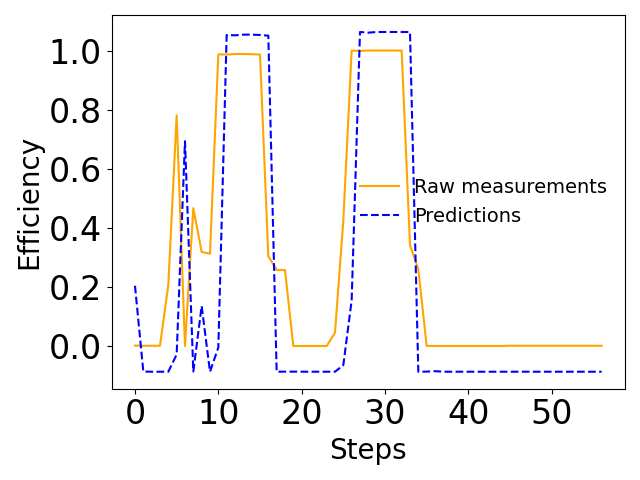

In [33]:
# print(result['predicted_value'])

from matplotlib import pyplot

%matplotlib widget

pyplot.clf()
pyplot.plot(result['actual_value'], '-', color='orange', label='Raw measurements')
pyplot.plot(result['predicted_value'], '--', color='blue', label='Predictions')
pyplot.xlabel('Steps', fontsize=20)
pyplot.ylabel('Efficiency', fontsize=20)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.legend(fontsize=14, frameon=False)
pyplot.tight_layout()
# prediction_out_figure = f'../experiments_result/figures_GWT/gcd_{job_id}_pred.png' # TODO